In [9]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce

In [10]:
def get_star(p):
    star = ''
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    return star

In [11]:
datanames = [('wvs_w7', 'wvs'),('pew', 'pew')]
lms = ['mcm', 'gpt2_token_pairs', 'gpt2-medium_token_pairs','gpt2-large_token_pairs', 'gpt3', 'gpt3_token_pairs', 
       'wvs_w7_gpt2_random_on_wvs_token_pairs']
lms_names = ['SBERT', 'GPT2', 'GPT2-MEDIUM','GPT2-LARGE','GPT3-QA','GPT3-PROBS', 'GPT2-Fine-tuned (Random)']
lm_scores = ['mcm_score','log prob difference','log prob difference','log prob difference', 'gpt3_score_mean','log prob difference', 'log prob difference']
main_models = ['mcm','gpt2-large_token_pairs','gpt3']
appendix_models = ['gpt2_token_pairs','gpt2-medium_token_pairs','gpt3_token_pairs']

In [110]:
def get_cluster_dfs(with_repeat = False):
    B = 1
    if with_repeat:
        B = 50
    list_rows_country = []
    list_rows_continent = []
    continents_df = pd.read_csv('../data/Countries-Continents.csv')
    continents = continents_df.Continent.unique()
    for i in range(len(lms)):
        for data_index in range(1):
            lm_index = lms.index(lms[i])

            lm = lms[lm_index]
            score = lm_scores[lm_index]
            data_name = datanames[data_index]

            emp_column = f'{data_name[1]}_score'
            lm_column = score

            if lm_index == len(lms) - 1:
                df = pd.read_csv(f'../data/{lm}.csv')
                df = df.loc[df['country'] != 'universal']

            else:
                df = pd.read_csv(f'../data/{data_name[0]}_{lm}.csv') 
            df = df.loc[~pd.isna(df[emp_column])]
            clusters_df= pd.read_csv(f'../data/rich_west_{data_name[1]}.csv')


            clusters = list(clusters_df.rich_west.unique())
            rich_western = 'United States, Australia, Netherlands, ...'
            non_rich_western = 'Turkey, Kazakhstan, Thailand, ...'


            for b in range(B):
                for c in clusters:
                    cluster_country = list(clusters_df.loc[clusters_df.rich_west == c].country.unique())
                    if with_repeat:
                        cluster_sample = np.random.choice(cluster_country, 11, False)
                    else:
                        cluster_sample = cluster_country
                    small_data = df.loc[df.country.isin(cluster_sample)]
                    r, p = scipy.stats.pearsonr(small_data[emp_column], small_data[lm_column])


                    if c == True:
                        countries_str = f'Rich & Western countries: {rich_western}, (n = 11)'
                    else:
                        countries_str = f'Non-rich | non-western countries: {non_rich_western}, (n = 44)'


                    row = {'cluster':c,'countries': countries_str,'countries_list':cluster_country,
                          'p': p,'r': r,'model': lms_names[i], 'data': data_name[1]}
                    list_rows_country.append(row)


                for c in continents:
                    cluster_country = list(continents_df.loc[continents_df.Continent == c].Country.unique())

                    cluster_country = [x for x in cluster_country if x in list(df.country.unique())]
                    if with_repeat:
                        cluster_sample = np.random.choice(cluster_country, min(5, len(cluster_country)), False)
                    else: 
                        cluster_sample = cluster_country
                    small_data = df.loc[df.country.isin(cluster_sample)]

                    r, p = scipy.stats.pearsonr(small_data[emp_column], small_data[lm_column])

                    countries_str = ", ".join(cluster_country)


                    row = {'continent':c + f', (n = {len(cluster_country)})','countries': countries_str,'countries_list':cluster_country,
                          'p': p,'r': r,'model': lms_names[i], 'data': data_name[1]}
                    list_rows_continent.append(row)
        
    country_cluster_df = pd.DataFrame(list_rows_country)
    country_continent_df = pd.DataFrame(list_rows_continent)
    return country_cluster_df,country_continent_df




In [111]:
sns.set(font_scale=1)
sns.set_style("ticks")

In [120]:
country_cluster_df,country_continent_df = get_cluster_dfs(False)

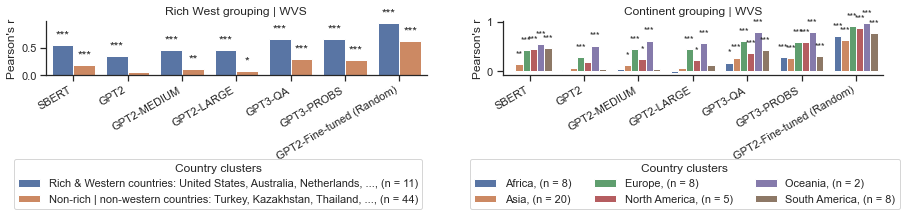

In [135]:

fig, axes = plt.subplots(1, 2, figsize = (15, 1))
ax = axes[0]
country_cluster_df_wvs = country_cluster_df.loc[country_cluster_df.data == 'wvs']

g = sns.barplot(data = country_cluster_df_wvs, x = 'model',y = 'r', hue = 'countries', ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(-0.1,-2), title = 'Country clusters')
ax.set_xticklabels(rotation=30, labels = g.get_xticklabels(),ha = 'right')
ax.set_xlabel('')
ax.set_ylabel('Pearson\'s r')
ax.set_title('Rich West grouping | WVS')
legend_labels = ax.get_legend_handles_labels()[-1]
for p in g.patches:
    
#     group = legend_labels[i % (len(legend_labels)) ]
#     model = lms_names[(i // 2) % len(lms_names)]
#     pval = np.max(country_cluster_df_wvs.loc[(country_cluster_df_wvs.model == model) & (country_cluster_df_wvs.countries == group)].p)
    r, y = p.get_height(),p.get_height()
    
    pval = np.mean(country_cluster_df_wvs.loc[country_cluster_df_wvs.r == r].p)
    star = get_star(pval)
#     print(model, group, pval, star)
    g.annotate(star, (p.get_x() + p.get_width() / 2., p.get_height()),fontsize = 12, 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    

ax = axes[1]
country_continent_df_wvs = country_continent_df.loc[country_continent_df.data == 'wvs']

g = sns.barplot(data = country_continent_df_wvs, x = 'model',y = 'r', hue = 'continent', ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(-0.1,-2), title = 'Country clusters', ncol = 3)
ax.set_xticklabels(rotation=30, labels = g.get_xticklabels(),ha = 'right')
ax.set_xlabel('')
ax.set_ylabel('Pearson\'s r')
ax.set_title('Continent grouping | WVS')

for p in g.patches:
    x = p.get_x()
    r, y = p.get_height(),p.get_height()
    pval = np.max(country_continent_df_wvs.loc[country_continent_df_wvs.r == r].p)
    star = get_star(pval)
    g.annotate(star, (p.get_x() + p.get_width() / 2., p.get_height()),fontsize = 9, 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    
    


sns.despine(left = False)
plt.savefig('figs/double_clustering_wvs.png', dpi = 150, bbox_inches = 'tight')


## WVS data correlation

In [46]:
df = pd.read_csv(f'../data/wvs_w7_gpt3_token_pairs.csv') 
cluster_country = list(continents_df.loc[continents_df.Continent == 'Europe'].Country.unique())
cluster_country = [x for x in cluster_country if x in list(df.country.unique())]
eu_data = df.loc[df.country.isin(cluster_country)]

cluster_country = list(continents_df.loc[continents_df.Continent == 'North America'].Country.unique())
cluster_country = [x for x in cluster_country if x in list(df.country.unique())]
na_data = df.loc[df.country.isin(cluster_country)]
            

In [47]:
len(eu_data.country.unique()),len(na_data.country.unique())

(8, 5)

In [49]:
ratings_eu = []
ratings_na = []
for topic in eu_data.topic.unique():
    
    eu_t = eu_data.loc[eu_data.topic == topic]['wvs_score'].mean()
    na_t = na_data.loc[na_data.topic == topic]['wvs_score'].mean()
    ratings_eu.append(eu_t)
    ratings_na.append(na_t)
    


print(scipy.stats.pearsonr(ratings_eu,ratings_na))

    

(0.938129742745483, 2.987816583064099e-09)
